<a href="https://colab.research.google.com/github/aanyamehta1/demand-forecasting-ey/blob/main/FMCG_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FMCG Sales Forecasting using Regression Analysis
**Project Overview:**
- Sales volume for 5 years at a daily level for approximately 50 unique products in 10 stores.
- Time-series forecasting demand for the first quarter of 2018.
- Seasonality - multivariate analysis where sales of one item in multiple stores could be correlared or multiple items in one store.

**Data Preparation**
- Aggregate data at the weekly level for each product, add other aggregation features.
- Clean and preprocess the data for training.

**Model Training**
- Utilize Python for model training.
- Implement parallel training for efficient processing of products.
- Consider using libraries like Pandas, NumPy, and Scikit-Learn for data manipulation and modeling.

**Forecasting and Analysis**
- Develop regression models for demand forecasting.
- Evaluate forecast accuracy and identify any biases.
- Analyze demand drivers such as promotional activities, seasonality, economic factors, etc.


#Importing Libraries

In [1]:
import os
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classification Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model Evaluation Libraries
from sklearn import metrics

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve,
                             roc_auc_score,
                             confusion_matrix)


In [2]:
# Ignore Warnings
from warnings import filterwarnings
filterwarnings('ignore')

#Data Cleaning & Preprocessing

#*Data Overview*
Training Dataset is very clean.

1. There is no missing data or null (NaN) values so no need to remove or impute values
2. Only numerical continuous features are present
3. From unique values given:
- Datatset contains 5 years of daily data from 2013 to 2017, so 366 days as accounting for leap year.
- Sales data available for 10 different stores and for 50 unique items.
- There is a considerable range in sales values suggesting variablity in sales across variables.

In [3]:
2# Loading Data
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1FOo8IdEJeQzfTr8s1iu7wWYqARMkHmsM')
test_df = pd.read_csv('https://drive.usercontent.google.com/download?id=1kaPv0ByPRO3bAqYfEyFmG1tidtbeY6Gd&authuser=0')

print(train_df.head())

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


In [4]:
# Check for missing values, duplicates, datatyppes, general description of dataset
def data_overview(df):
  print(df.shape)
  print(df.nunique())
  print(df.describe())
  print(df.info())
  print(df.isnull().sum().to_string())

data_overview(train_df)

(913000, 4)
date     1826
store      10
item       50
sales     213
dtype: int64
               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None
date     0
store    0
item     0
sales    0


In [5]:
# Ensure date column is in datetime obj format YYYY/MM/DD
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

#Feature Engineering and Data Aggregation

Here features will be added from given columns to conduct EDA. This will help to see temporal and cyclical patterns in sales data.

Additional time-based features were added to do further analysis within the seasonality scope:
holidays, weekday/weekened, month/year/week etc.

In [6]:
# Add week, month, and year features for EDA
train_df['week'] = train_df['date'].dt.isocalendar().week
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['day_of_week'] = train_df['date'].dt.dayofweek

train_df['is_weekend'] = (train_df['date'].dt.dayofweek >= 5).astype(int)

## Exploratory data analysis and visualization

This will show trends, distributions, correlations of sales across stores, items and dates.

Then, we look at aggregated features of month, weeks and years. Features will be plotted and analyzed below.

Line graph shows a cyclical sales trend.
Overall increase from 2013 to 2018, maximum reached in between 2 years, middle month.

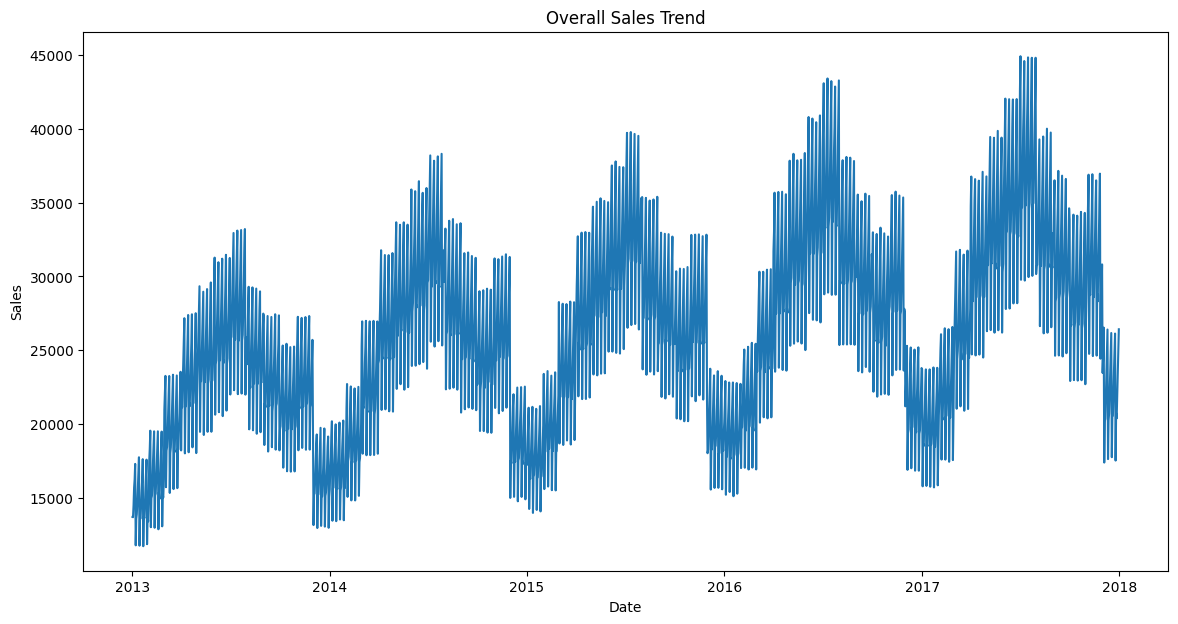

In [7]:
store_sales = train_df.groupby('store')['sales'].sum().reset_index()
monthly_sales = train_df.groupby('month')['sales'].sum().reset_index()
yearly_sales = train_df.groupby('year')['sales'].sum().reset_index()
weekly_sales = train_df.groupby('week')['sales'].sum().reset_index()
daily_sales = train_df.groupby('day_of_week')['sales'].sum().reset_index()

# Mean weekday compared to mean weekend sales
mean_weekend_sales = train_df.groupby('is_weekend')['sales'].mean().reset_index()

# store, item, sales, date
# predict sales per item, per store, each day

# Numerical Analysis
plt.figure(figsize=(14, 7))
plt.plot(train_df.groupby('date')['sales'].sum())
plt.title('Overall Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

#Univariate Analysis


**Overall Insights and Trends from Plots**

- Yearly sales have increased linearly overall from 2013 to 2017, which could be accounted to population growth, increased disposable income, e-commerce and technology with convenience over years and the adoption to more sustainable FMCGs implemented in stores. There is a seasonal pattern.

- Across stores, 2, 3, 8, 10 show highest distribution of sales, and 5, 6, 7 and 1 with least sales. The remaining stores show moderate sales. This could be due to reputation of stores and customer service, product development, consumer preferences and geographical location. Pie chart suggests focusing on improving lower-performing stores.

- The sales per month increases over time and the data shows some seasonality with sales higher in summer (June to August) and lower in the winter (Dec to Feb). This could be due to weather, holidays or change in consumer behaviour.

- Linear incline in sales from Monday to Sunday. This could be as consumers may stock up on FMCGs over weekend and buy smaller quantities on weekdays for immediate needs. Average weekend sales are higher than weekday. Weekends may involve more leisure/entertainment activities, hence increased demand for FMCGs and stores might offer weekend-specific promotions incentivizing larger purchases.

- Item sales in ascending order of highest sales of the 50 unique items. This will be used later to conduct multi and bi-variate analysis.

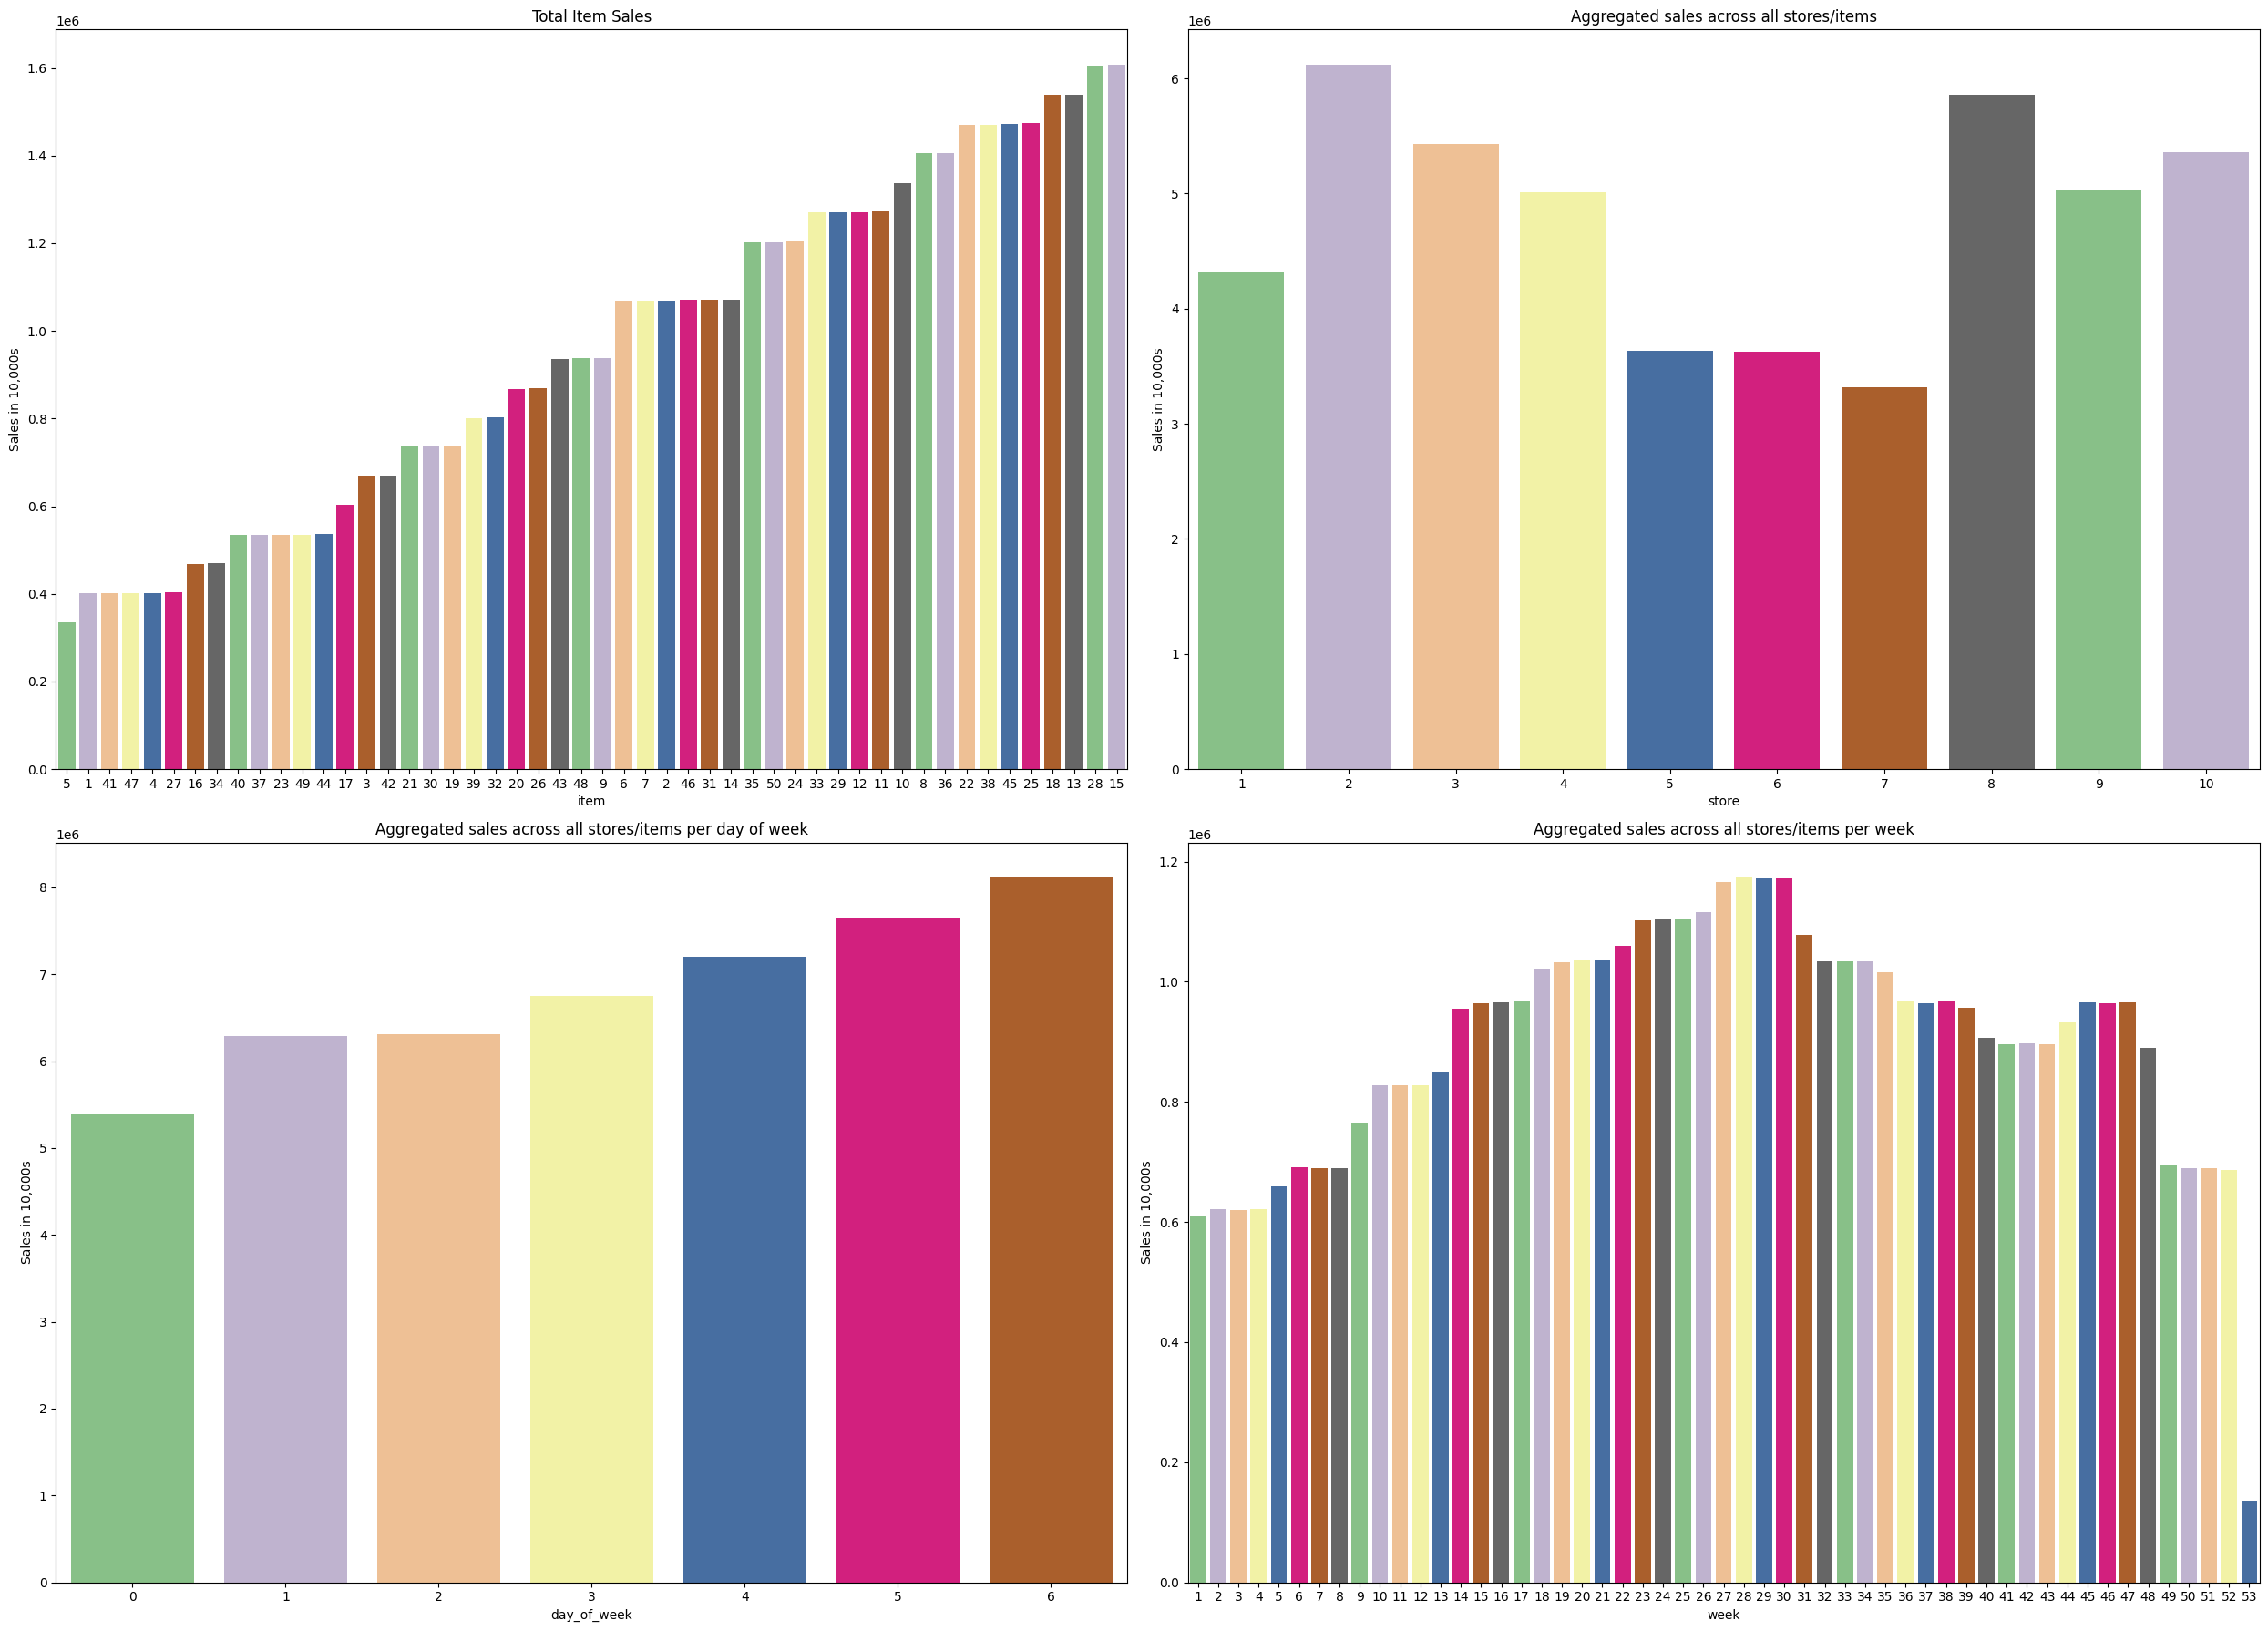

In [8]:
# Categorical Data Univariate Plots
def barplot(ax, df, x, y, title):
    sns.barplot(ax=ax, x=x, y=y, data=df, order=df[x], palette='Accent')
    ax.set_title(title)
    ax.set_ylabel('Sales in 10,000s')
    ax.set_xlabel(x)

fig, axes = plt.subplots(2, 2, figsize=(25, 18))
item_sales = train_df.groupby('item')['sales'].sum().reset_index().sort_values(by='sales',ascending=True)
barplot(axes[0, 0], item_sales, 'item', 'sales', 'Total Item Sales')

barplot(axes[0, 1], store_sales, 'store', 'sales', 'Aggregated sales across all stores/items')
barplot(axes[1, 0], daily_sales, 'day_of_week', 'sales', 'Aggregated sales across all stores/items per day of week')
barplot(axes[1, 1], weekly_sales, 'week', 'sales', 'Aggregated sales across all stores/items per week')

plt.tight_layout()
plt.show()

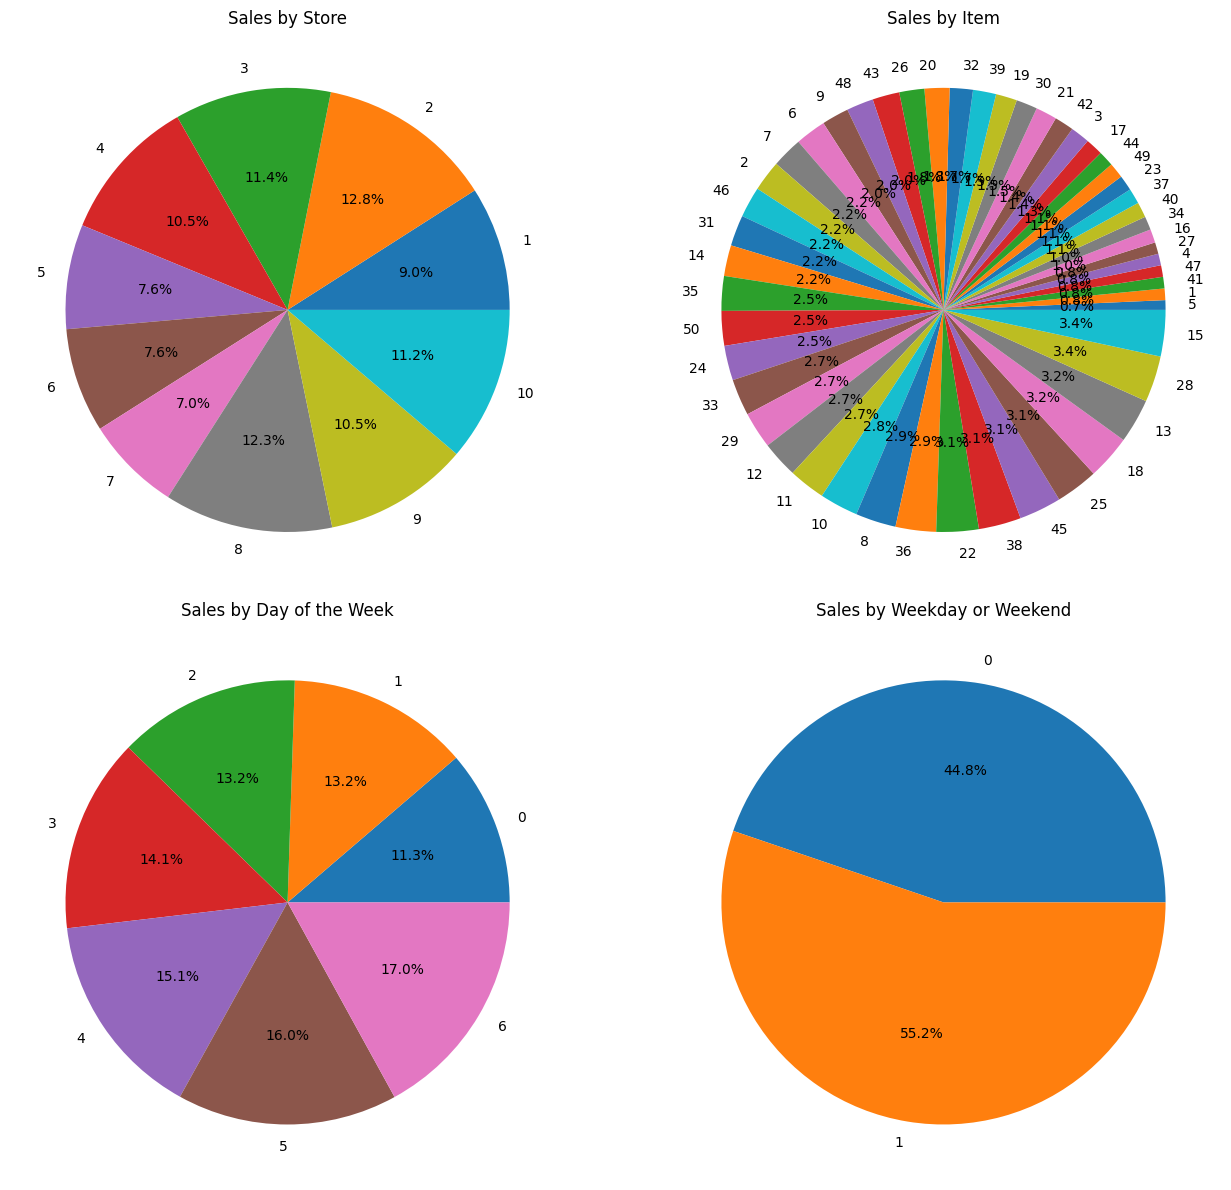

In [9]:
def piechart(ax, x, labels, title):
    ax.pie(x, labels=labels, autopct='%1.1f%%')
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

piechart(axes[0, 0], store_sales['sales'], store_sales['store'], 'Sales by Store')
piechart(axes[0, 1], item_sales['sales'], item_sales['item'], 'Sales by Item')
piechart(axes[1, 1], mean_weekend_sales['sales'], mean_weekend_sales['is_weekend'], 'Sales by Weekday or Weekend')
piechart(axes[1, 0], daily_sales['sales'], daily_sales['day_of_week'], 'Sales by Day of the Week')
plt.tight_layout()
plt.show()

**Overall Insights and Trends from Plots**

- Seasonality patterns shown every year, linked to months with sales incline in Summer and Winter
- Monthly seasonality shown by day of week, repeated pattern each month
- Weekly pattern occuring across all stores, sharp incline towards end of week, highest sales on weekend
The sales during summer months have greater variation, more dispersed. Overall, there are lots of outliers and data is mainly left-skewed. Hence, lower sales across all variables.

There is a clear seasonal trend across weeks, hence we will aggregate weekly sales and conduct further analysis here.

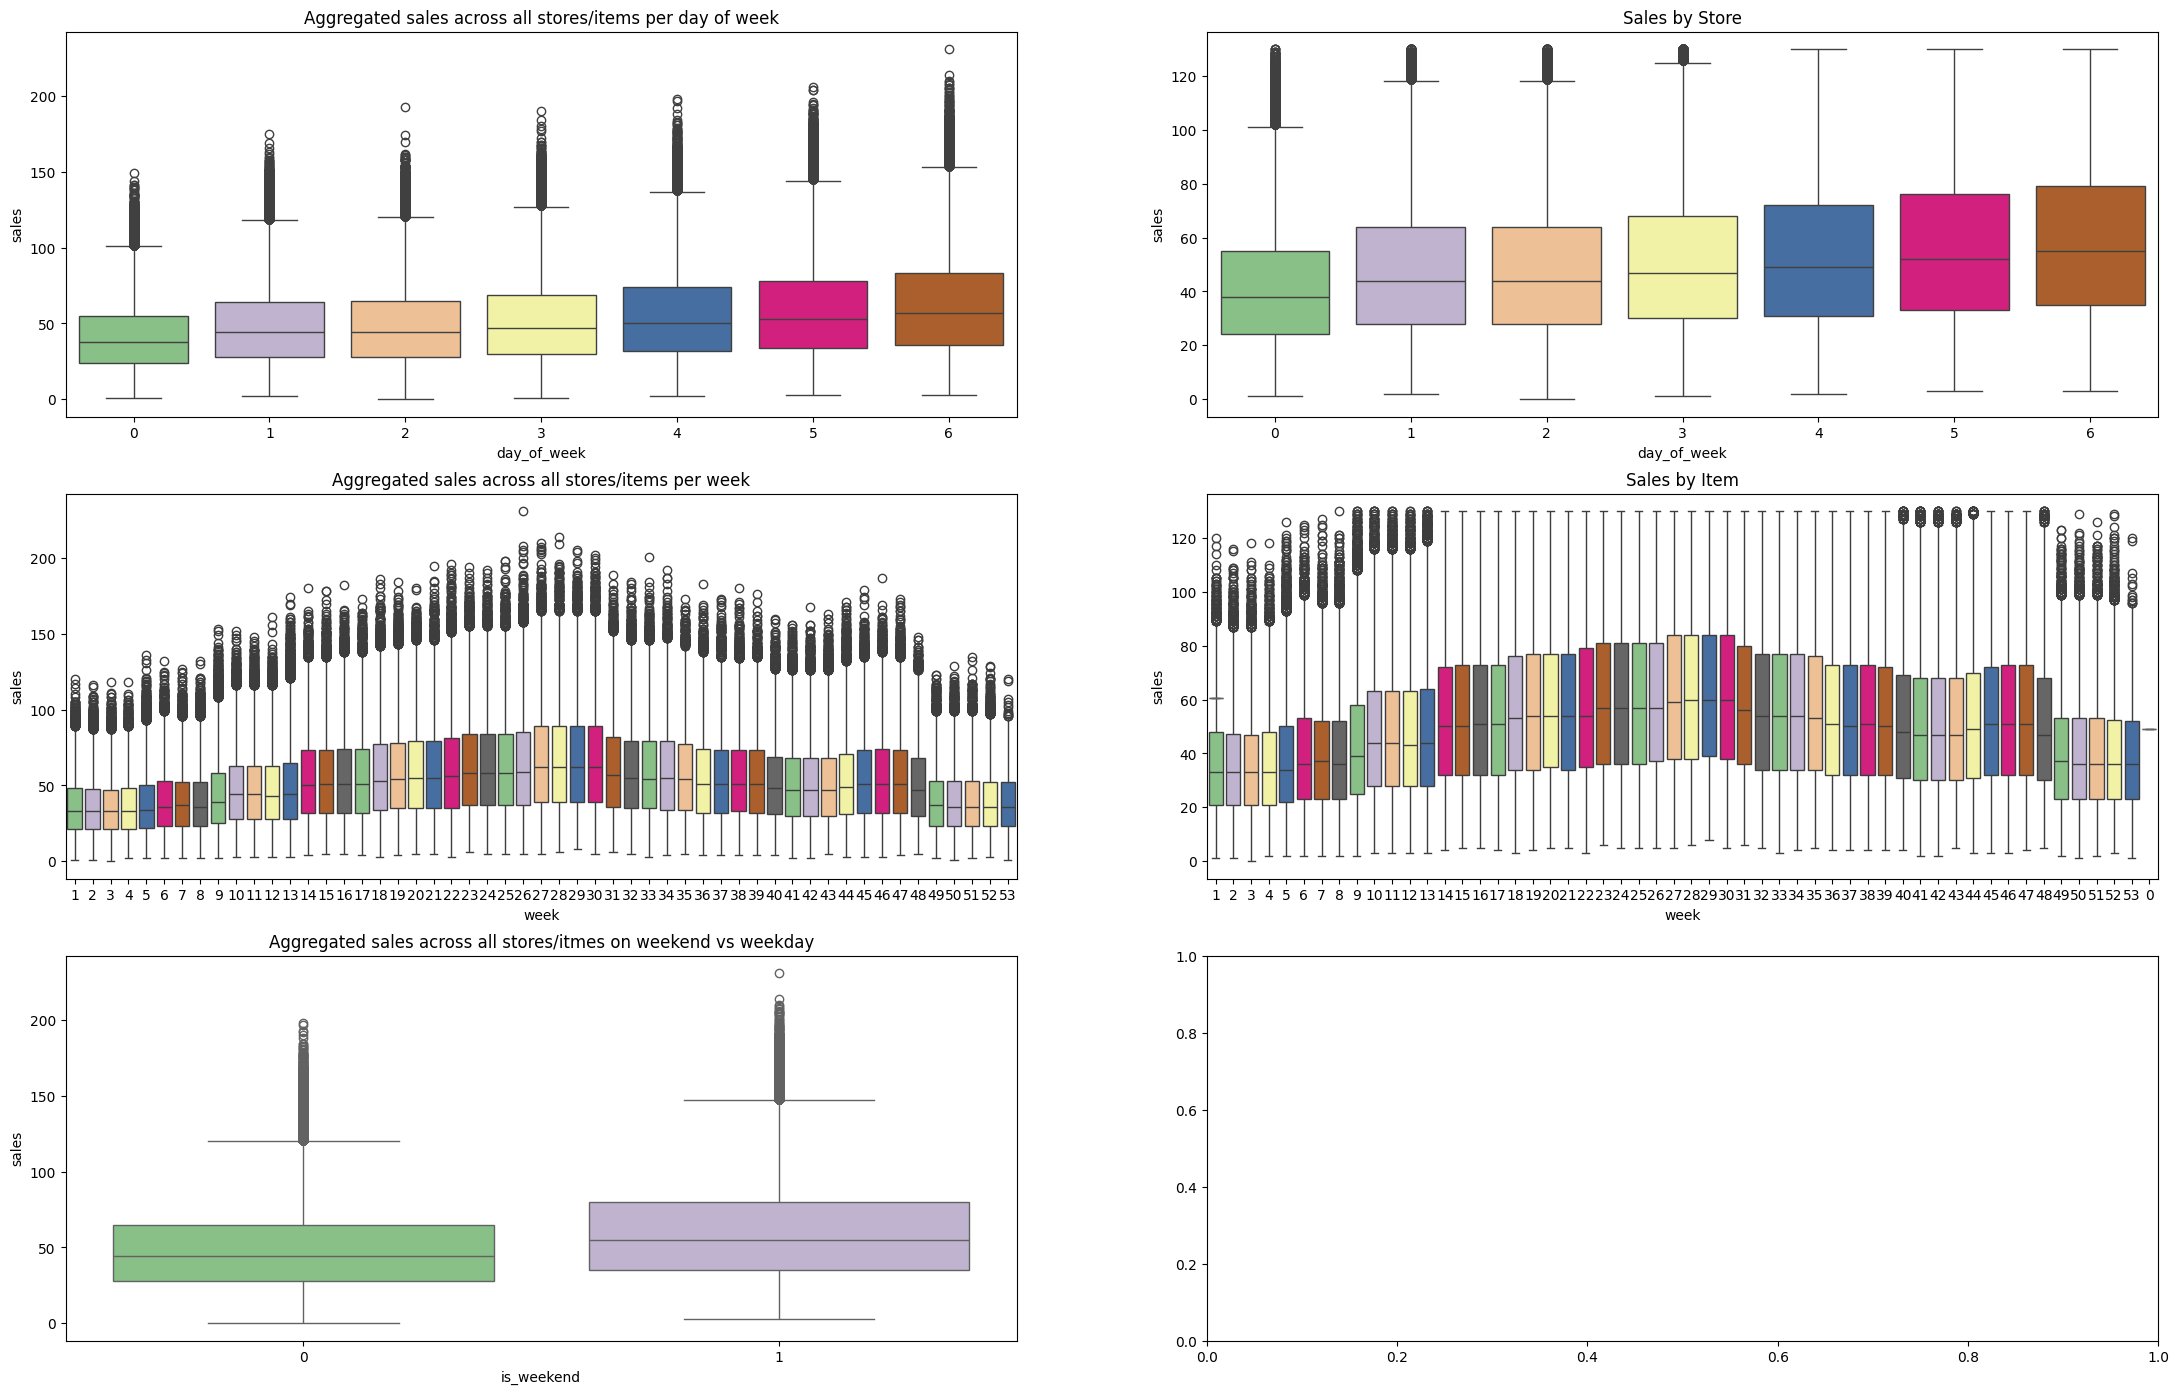

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [10]:
#Boxplot - Useful for detecting outliers and understanding the spread and skewness of the data.
def boxplot(ax, df, x, y, title):
    plt.figure(figsize=(14, 7))
    sns.boxplot(ax=ax, x=x, y=y, data=train_df, palette='Accent').set(title=title)

def filtersOutliers(df, col, x, ax, title):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    filtered_df = df[(df[col] >= lower) & (df[col] <= upper)]
    sns.boxplot(ax=ax, x=x, y=col, data=filtered_df, palette='Accent').set(title=title)

fig, axes = plt.subplots(3, 2, figsize=(27, 17))

boxplot(axes[0, 0], train_df, 'day_of_week', 'sales', 'Aggregated sales across all stores/items per day of week')
boxplot(axes[1, 0], train_df, 'week', 'sales', 'Aggregated sales across all stores/items per week')
boxplot(axes[2, 0], mean_weekend_sales, 'is_weekend', 'sales', 'Aggregated sales across all stores/itmes on weekend vs weekday')

filtersOutliers(train_df, 'sales', 'day_of_week', axes[0, 1], 'Sales by Store')
filtersOutliers(train_df, 'sales', 'week', axes[1, 1], 'Sales by Item')
filtersOutliers(mean_weekend_sales, 'sales', 'is_weekend', axes[1, 1], 'Sales by Item')
plt.tight_layout()
plt.show()

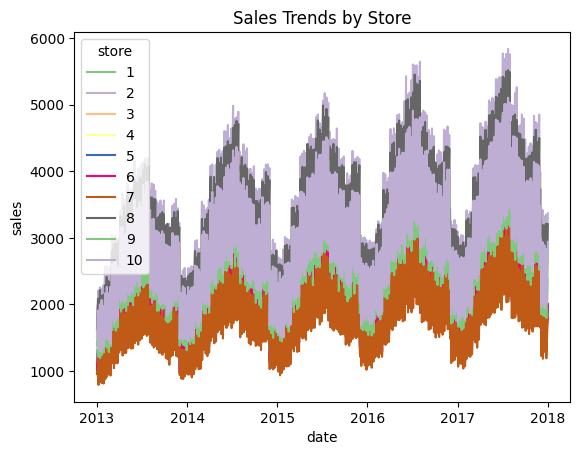

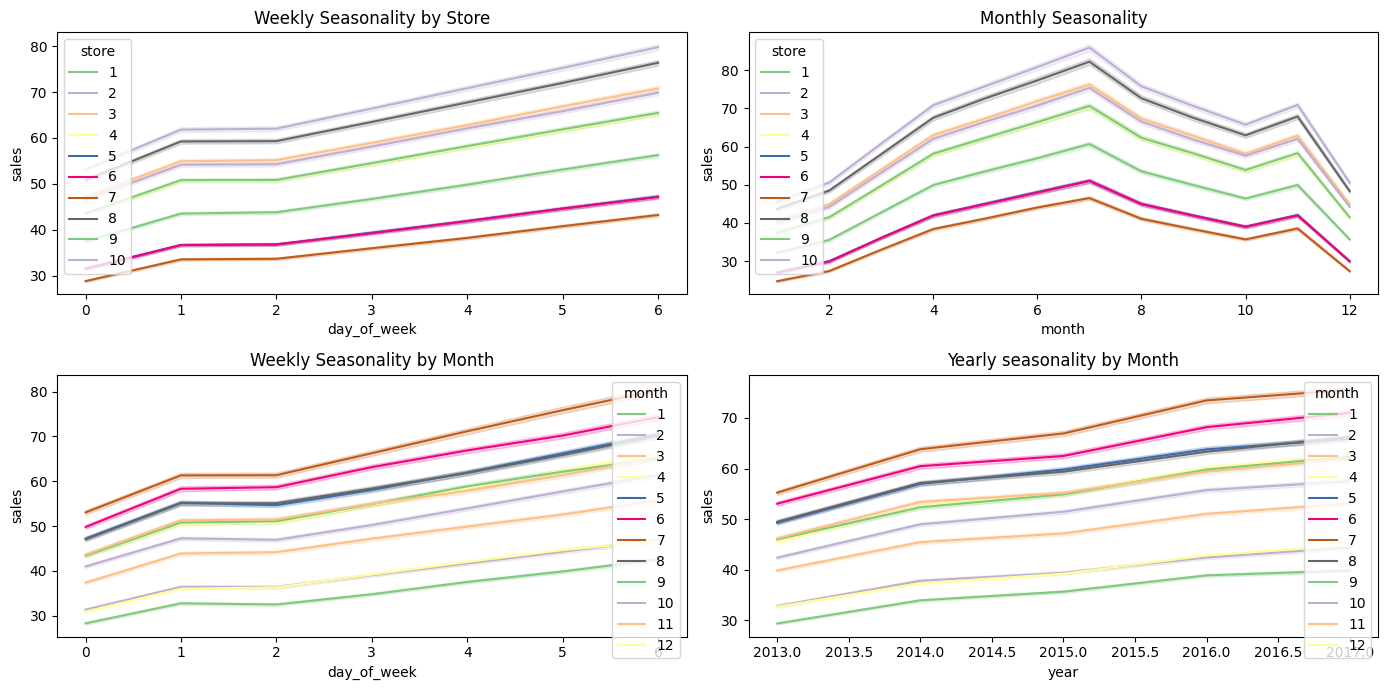

In [11]:
store_date_sales = train_df.groupby(['store', 'date'])['sales'].sum().reset_index()
sns.lineplot(x='date', y='sales', hue='store', data=store_date_sales, palette='Accent')
plt.title('Sales Trends by Store')

def plot_seasonality(df, y, x, key, title, ax):
    _=train_df.groupby([key, x])[y].sum().reset_index()
    sns.lineplot(x=x, y=y, hue=key, data=train_df, palette='Accent', ax=ax).set(title=title)

fig, axes = plt.subplots(2,2)
plot_seasonality(train_df, 'sales', 'day_of_week', 'store', 'Weekly Seasonality by Store', ax=axes[0,0])
plot_seasonality(train_df, 'sales', 'month', 'store', 'Monthly Seasonality', ax=axes[0,1])
plot_seasonality(train_df, 'sales', 'day_of_week', 'month', 'Weekly Seasonality by Month', ax=axes[1,0])
plot_seasonality(train_df, 'sales', 'year', 'month', 'Yearly seasonality by Month', ax=axes[1,1])
fig.set_size_inches(14, 7)
plt.tight_layout()
plt.show()

**Overall Insights and Trends from Plots**

Distribution of sales exhibits a right-skewed distribution, indicating that most sales occur in the lower range (20-40 range), with a long tail of higher sales values.

While low to moderate sales are common, there are occasional spikes in sales. Further analysis can be done with other graphs to see if seasonal trends, promotions/holidays, inventory or any other factors cause these outliers.

Notable variations in sales volume across the items.

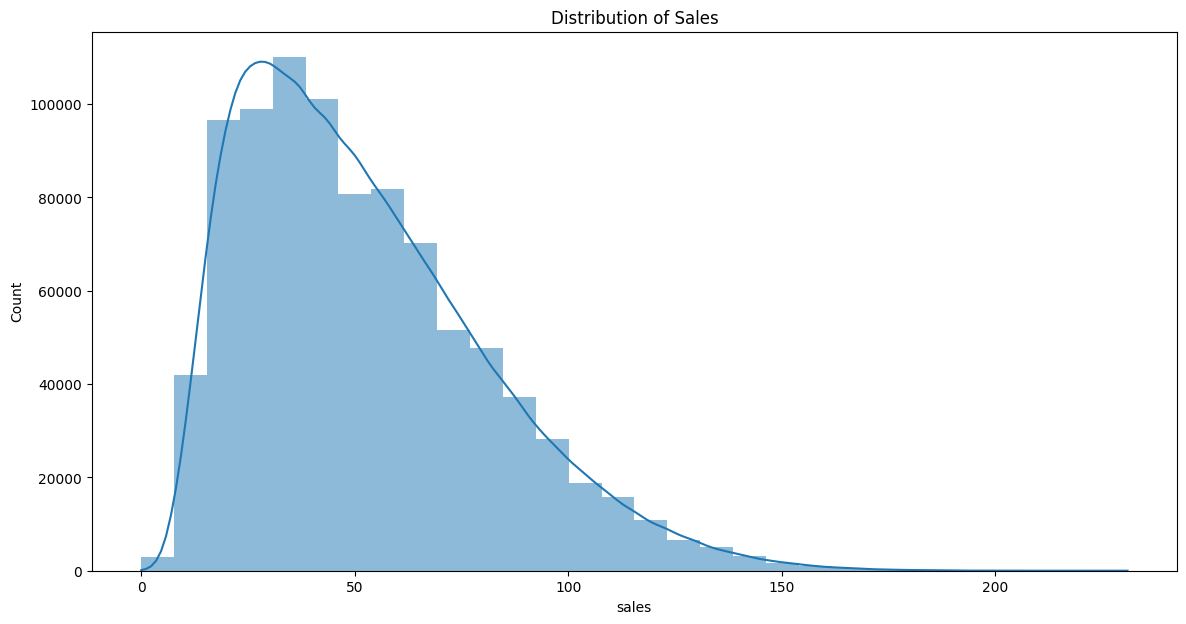

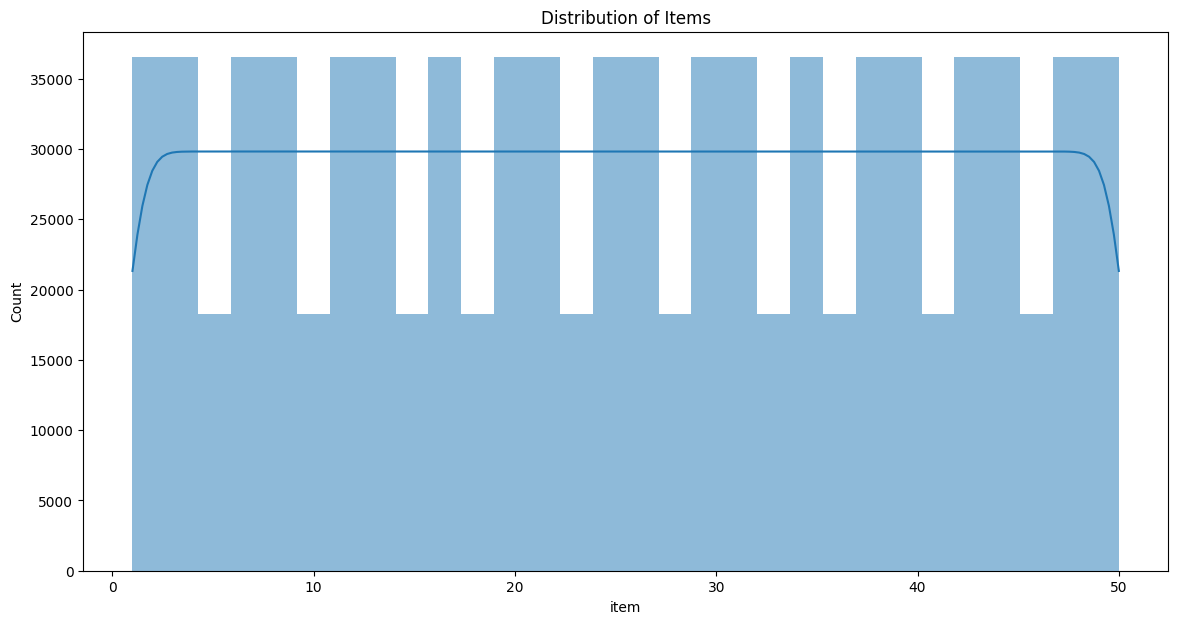

In [12]:
def histplot(df, x, title):
    plt.figure(figsize=(14, 7))
    sns.histplot(df[x], kde=True, bins=30, edgecolor='None')
    plt.title(title)

histplot(train_df, 'sales', 'Distribution of Sales')
histplot(train_df, 'item', 'Distribution of Items')

# Bi-Variate and Multi-Variate Analysis

The graphs show the top 5 items (highest sales) and their distribution in the 10 stores. This was to show if any particular items were sold more at any particular stores, regardless of their total sales. However, the distribution shows that the items follow the distribution of the top selling stores.

[Text(0.5, 1.0, 'Total Sales by Store and Item')]

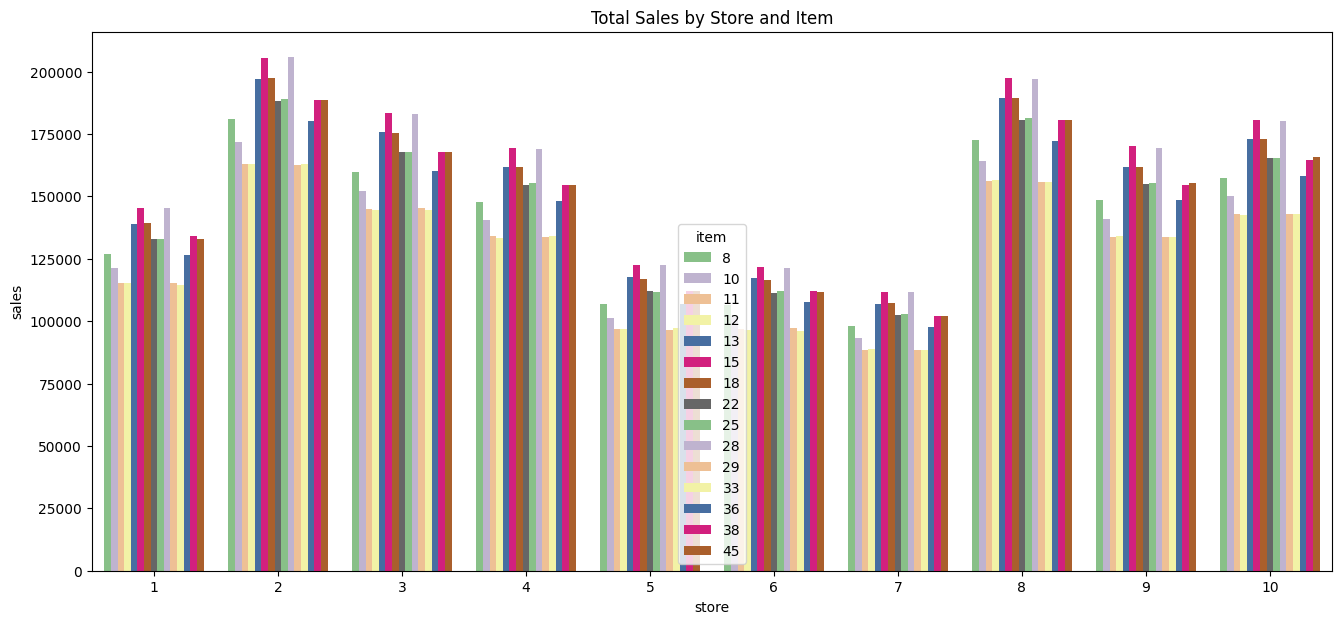

In [13]:
store_item_sales = train_df.groupby(['store', 'item'])['sales'].sum().reset_index()

plt.figure(figsize=(16, 7))

top4 = item_sales.nlargest(15, 'sales')['item']
filterdf = pd.merge(store_item_sales, top4, on='item')

sns.barplot(x='store', y='sales', hue='item', data=filterdf, palette='Accent').set(title='Total Sales by Store and Item')

The graph shows the day of week compared to the 5 highest selling products, to show if any particular product is selling more higher on a prticular week. All products show an increase in sales across the week, and a similar distribution where the highest selling product is also the highest selling of the particular day_of_week. This is the total sales of item x at all stores, and there is no particularly significant correlation between an item and a particular store.

[Text(0.5, 1.0, 'Total Sales by Day of Week and Top 5 Selling Items')]

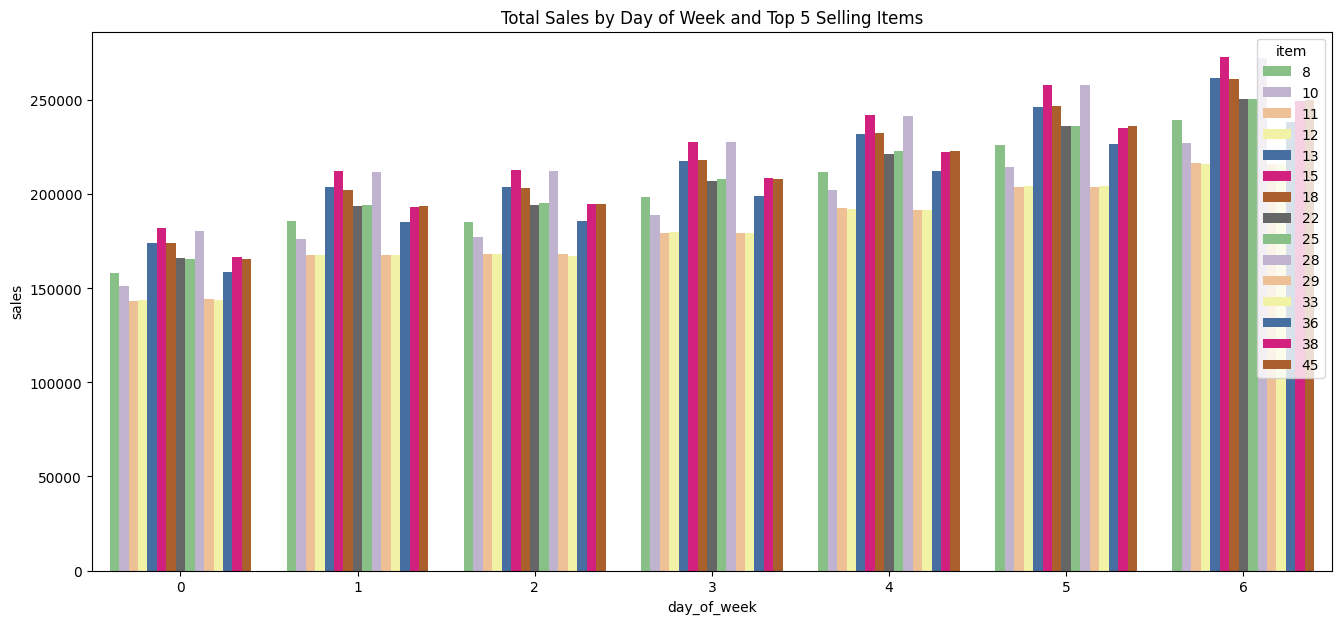

In [14]:
store_item_sales = train_df.groupby(['day_of_week', 'item'])['sales'].sum().reset_index()
plt.figure(figsize=(16, 7))

top4 = item_sales.nlargest(15, 'sales')['item']
filterdf = pd.merge(store_item_sales, top4, on='item')

sns.barplot(x='day_of_week', y='sales', hue='item', data=filterdf, palette='Accent').set(title='Total Sales by Day of Week and Top 5 Selling Items')

#Summary Statistics

In [15]:
mean_sales = train_df['sales'].mean()
median_sales = train_df['sales'].median()
mode_sales = train_df['sales'].mode()[0]
variance_sales = train_df['sales'].var()
std_dev_sales = train_df['sales'].std()

summary_stats = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Mode', 'Variance', 'Standard Deviation'],
    'Value': [mean_sales, median_sales, mode_sales, variance_sales, std_dev_sales]
})

print(summary_stats)

skewness_sales = train_df['sales'].skew()
print(skewness_sales)
print(train_df.head())

            Statistic       Value
0                Mean   52.250287
1              Median   47.000000
2                Mode   30.000000
3            Variance  829.505873
4  Standard Deviation   28.801144
0.8671122960235805
        date  store  item  sales  week  month  year  day_of_week  is_weekend
0 2013-01-01      1     1     13     1      1  2013            1           0
1 2013-01-02      1     1     11     1      1  2013            2           0
2 2013-01-03      1     1     14     1      1  2013            3           0
3 2013-01-04      1     1     13     1      1  2013            4           0
4 2013-01-05      1     1     10     1      1  2013            5           1


#Outlier Detection

In [16]:
def filtersOutliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df
    print(df)



# Correlation Analysis

             date  store  item  sales  week  month  year  day_of_week  \
0      2013-01-01      1     1     13     1      1  2013            1   
1      2013-01-02      1     1     11     1      1  2013            2   
2      2013-01-03      1     1     14     1      1  2013            3   
3      2013-01-04      1     1     13     1      1  2013            4   
4      2013-01-05      1     1     10     1      1  2013            5   
...           ...    ...   ...    ...   ...    ...   ...          ...   
912995 2017-12-27     10    50     63    52     12  2017            2   
912996 2017-12-28     10    50     59    52     12  2017            3   
912997 2017-12-29     10    50     74    52     12  2017            4   
912998 2017-12-30     10    50     62    52     12  2017            5   
912999 2017-12-31     10    50     82    52     12  2017            6   

        is_weekend  
0                0  
1                0  
2                0  
3                0  
4                1

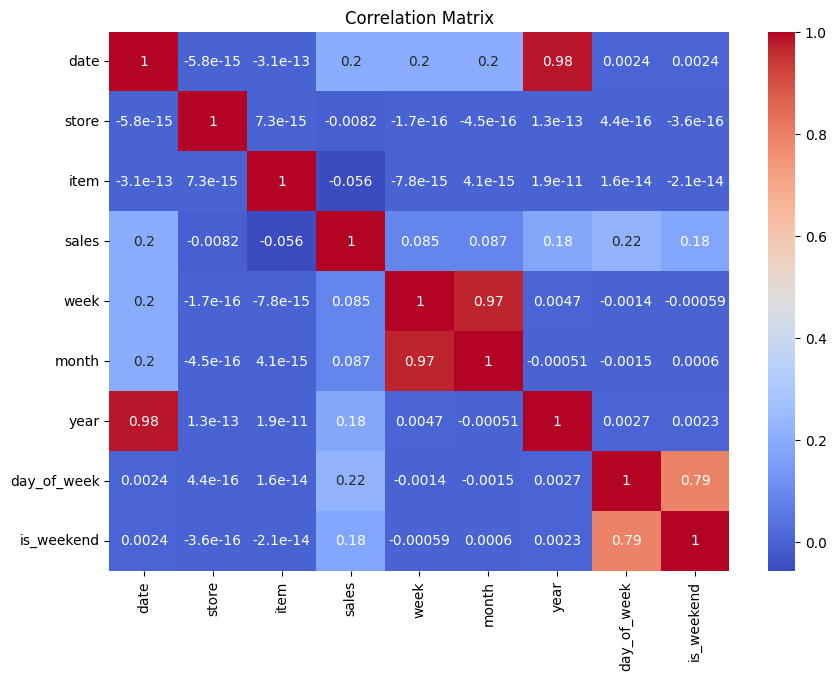

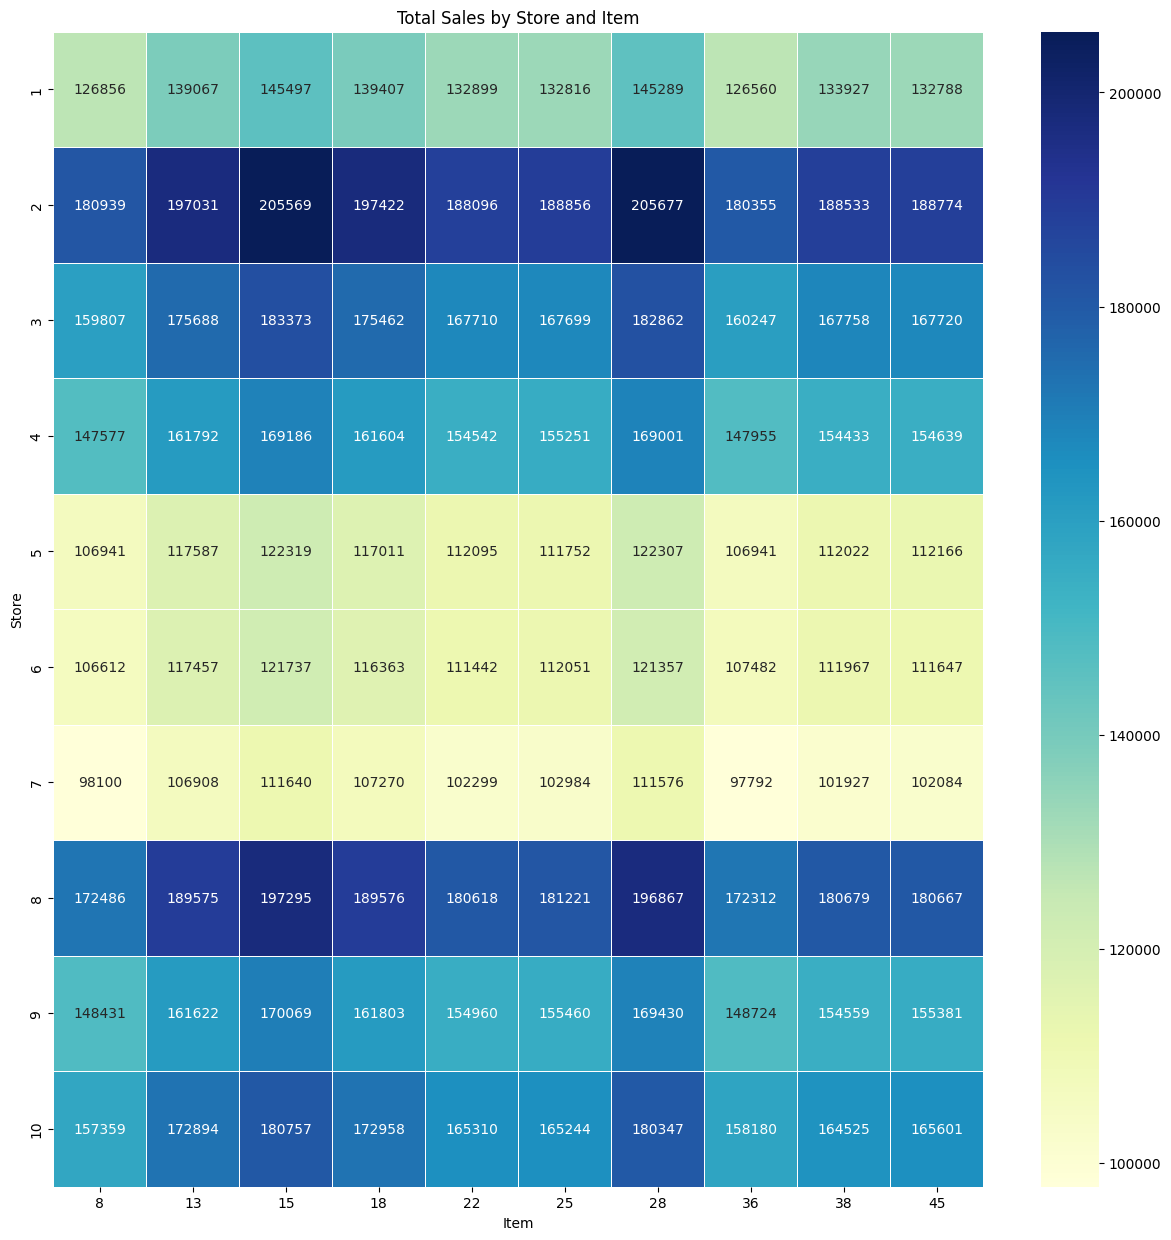

In [17]:
train_df.merge(store_sales)
print(train_df)


correlation_matrix = train_df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pivot the DataFrame to create a matrix of total sales by store and item
store_item_sales = train_df.groupby(['store', 'item'])['sales'].sum().reset_index()

high25 = store_item_sales.nlargest(25, 'sales')['item']
high25 = high25.drop_duplicates()
filterdf = pd.merge(store_item_sales, high25, on='item')

sales_pivot = filterdf.pivot_table(index='store', columns='item', values='sales')

plt.figure(figsize=(15, 15))
sns.heatmap(sales_pivot, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)
plt.title('Total Sales by Store and Item')
plt.xlabel('Item')
plt.ylabel('Store')
plt.show()

Sales Forecasting
- Demand != Sales


Predicting total sales volumes of all items per store, can disregard columns of item id and store id. To train the model for forecasting sales for 3 months. We will create different models and compare actual vs predicted sales, train the models and monitor them for generating forecasts for future dates.

To use time-series forecasting, data must be linear and stationary. Our dataset has trends, seasonality and has irregularity and cyclical components of time-series.

In [18]:
from statsmodels.tsa.stattools import adfuller

# Building Model and Metric Evaluation

In [19]:
# Split to features (x) and targer (y)
train_df_dummies = pd.get_dummies(train_df, columns=['month', 'year', 'day_of_week'], drop_first=True)
train_df_dummies = train_df_dummies.applymap(lambda x: 1 if x else 0)


features = ['day_of_week', 'month']
target = 'sales'

X = train_df[features]
y = train_df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import xgboost as xgb
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(),
}

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_smape = smape(y_train, y_pred_train)
    test_smape = smape(y_test, y_pred_test)


    print(f"{name} - Train SMAPE: {train_smape:.2f}%, Test SMAPE: {test_smape:.2f}%")

diff = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
diff.head(5)

Linear Regression - Train SMAPE: 45.13%, Test SMAPE: 45.13%
XGBoost - Train SMAPE: 42.99%, Test SMAPE: 42.91%


,Actual,Predicted
491212,21,39.946392
64903,15,43.281528
36378,100,65.851906
133834,93,70.106247
633538,33,41.080425


In [20]:
from scipy.stats import f_oneway, ttest_ind

anova_results = f_oneway(y_test, y_pred_test)

print("ANOVA results:")
print(anova_results)

r2 = r2_score(y_test, y_pred_test)
print("R-squared:", r2)

p_value = anova_results[1]
print("p-value:", p_value)


ANOVA results:
F_onewayResult(statistic=0.6635571992692456, pvalue=0.41530745145958203)
R-squared: 0.16393706292434396
p-value: 0.41530745145958203
